In [52]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time    : 2022/9/30 09:23
# @Author  : Wang Yujia
# @File    : GT_fixed_symmetry_gen.ipynb
# @Description : 根据GT_fixed_symmetry_gen_demo.ipynb，计算fixed-price auction的data。ref：信息不对称的paper里symmetry的情况。


# 0. what for
1. 在`GT_fixed_symmetry_gen_demo.ipynb`上实验过的思路，现在一次性输入所有的auction settings，得到相应的输出
2. **Steps**：
    - collect GT计算需要的features: `features_GT`，NN需要的features：`unique_setting`
        - features_GT = ['bidfee','retail','finalprice']
        - unique_setting = ['product_id', 'bidincrement', 'bidfee','retail','finalprice'] *[Unsure for now]*
        - Note：对于GT来说可能会出现不同的商品对应同样的retail，需要把他们当做不同的商品处理。GT并不在意是什么商品，只是在意`retail`大小
    - 根据`features_GT`计算GT预测的结果`n`和`p`
3. **Attention**：GT可以用一个features_GT来generate一组结果。但是对于NN而言，unique setting和GT_setting是两回事，前者更精细，包含的features更多。
    - 计算的时候直接忽略掉'product_id'，后面和target作比较的时候可以merge起来

# 1. Preparations
## 1.1 全局设置

In [53]:
# 经过threshold==16 filter之后，得到的dataset
data_selected_path = "../data/info_asymm/datawithnp_fixed_symmetry_selected.csv"

# output path
data_path_root = "../data/info_asymm/results/fixed_symmetry/"
filename_head = "GT_fixed_symmetry_"
filename_tail = ".csv"

# GT计算需要的features
product_id = ['product_id']
# 在这里认为GT连'product_id'的信息都不需要，囊括这个只是为了画图
features_GT = ['bidfee','retail','finalprice']
# 存在'product_id'相同但是'retail'不同的情况！
# 按理说'finalprice'也应该成为一个settings，fixed-price中越低的要价可以吸引越多的bidders
unique_setting = ['product_id', 'bidincrement', 'bidfee','retail']

import numpy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator # 用于设置刻度间隔

## 1.2 读取data

In [54]:
data = pd.read_csv(data_selected_path, encoding="utf-8")

# 2. GT_model: fixed-price auction model in symmetry situation
## 2.1 提取GT计算需要的features和data
1. 注意`drop_duplicates()`的目的是，对GT model来说，它的setting和NN的setting是不一样的，这里只需要要保留GT计算需要的setting就好

In [62]:
# 2.1.1 extract data
data_for_GT = data[features_GT].copy()
data_for_GT = data_for_GT.drop_duplicates().copy()
print("For symmetry GT model in "
      "fixed-price auctions, there are *{}* settings waiting to be inferred.".format(data_for_GT.shape[0]))

# 2.1.2 设置
b = np.array(data_for_GT.bidfee*0.01)          # bid fee (cent to dollar)
v = np.array(data_for_GT.retail)               # valuation
p = np.array(data_for_GT.finalprice)           # fixed-price charged to the winner

# 对GT-model来说，有A个不同的settings，因此需要计算`A`组结果
A = data_for_GT.shape[0]

# 2.1.3 根据i，得到Key/ features_GT
def get_key_from_index(i):
    key_i = list(data_for_GT[features_GT].iloc[i,:])   # 取出key/ uniq features
    # make sure key_i_str is tuple which is hashable
    key_i_str = (str(key_i[0]),str(key_i[1]),str(key_i[2]))
    return key_i_str

For symmetry GT model in fixed-price auctions, there are *77* settings waiting to be inferred.
aaaaa:  898.9145454545454


## 2.2 K
1. $n$ 的threshold $K$ 设置为ascending-price下的$Q$的中位数: $K = 500$ (中位数是490)
2. 但是这个效果不好，应该设置更大一点

In [56]:
K = 1000
print("The threshold is: ",K)

The threshold is:  1000


## 2.3 U
1. 计算`U`，在fixed-price下，`U`不会随着轮数的增加而变化
2. `U`作为一个**dict**，它的key是`unique_setting`,每一个key对应一个常数. 因此`U`的shape应该为：`A*1`
3. $u = 1-b/(v-p)$

In [75]:
U = dict()

# for every uniq setting i
for i in range(0,A):
    # Get the key of i
    key_i = get_key_from_index(i)
    U[key_i] = 1.0-b[i]/(v[i]-p[i])

assert(len(U) == A)

print("U is Prepared Well")
sum(U.values()) / len(U)

U is Prepared Well


0.9986046649864037

## 2.4 N
1. 容易获取N，在fixed-price下，它的长度是`A*K`
2.

In [58]:
N = dict()

# for every uniq setting i
for i in range(0,A):
    key_i = get_key_from_index(i)              # Get the key of i
    N[key_i] = np.arange(0,K+1)

print("N is Prepared Well.")

N is Prepared Well.


## 2.5 P
1. `P`作为一个**dict**，它的key是`unique_setting`,每一个key对应一个大小为(K+2)的list. 因此`P`的shape应该为：`A*(K+1)`
2. 对于某一个确定的setting，`P[key_i]`有`K`个有效数字，有效index从`0`开始，因此`P[key_i]`的长度is a constant `K+1`
3. `P[key_i]`和`U[key_i]`的有效长度都是`K+1`，只不过`U[key_i]`为了保持意义，下标从`1`开始

In [59]:
P = dict()

# for every uniq setting i
for i in range(0,A):
    key_i = get_key_from_index(i)              # Get the key of i
    P[key_i] = np.array([0.0]*(K+1))
    P[key_i][0] = 1 - U[key_i]
    # for every period j in the auction with uniq setting i
    for j in range(1,(K)):
        P[key_i][j] = P[key_i][j-1] * U[key_i]
    # set specifically for Kth round
    P[key_i][K] = 1-np.sum(P[key_i])
    assert(len(P[key_i]) == len(N[key_i]),"P should record all the durations record in N")
    print("The sum of P_{0} is: {1}".format(i,np.sum(P[key_i])))

print("\nP is Prepared Well.")

The sum of P_0 is: 0.9999999999999999
The sum of P_1 is: 1.0
The sum of P_2 is: 1.0
The sum of P_3 is: 1.0
The sum of P_4 is: 0.9999999999999999
The sum of P_5 is: 1.0
The sum of P_6 is: 1.0
The sum of P_7 is: 1.0
The sum of P_8 is: 0.9999999999999999
The sum of P_9 is: 1.0
The sum of P_10 is: 0.9999999999999999
The sum of P_11 is: 1.0
The sum of P_12 is: 1.0
The sum of P_13 is: 1.0
The sum of P_14 is: 1.0
The sum of P_15 is: 1.0
The sum of P_16 is: 1.0
The sum of P_17 is: 1.0
The sum of P_18 is: 1.0
The sum of P_19 is: 1.0
The sum of P_20 is: 1.0
The sum of P_21 is: 1.0
The sum of P_22 is: 1.0
The sum of P_23 is: 1.0
The sum of P_24 is: 1.0
The sum of P_25 is: 1.0
The sum of P_26 is: 1.0
The sum of P_27 is: 1.0
The sum of P_28 is: 1.0
The sum of P_29 is: 1.0
The sum of P_30 is: 0.9999999999999999
The sum of P_31 is: 1.0
The sum of P_32 is: 1.0
The sum of P_33 is: 1.0
The sum of P_34 is: 1.0
The sum of P_35 is: 1.0
The sum of P_36 is: 1.0
The sum of P_37 is: 1.0
The sum of P_38 is: 1.0

<>:13: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:13: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:13: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-59-8e6c9e7d1e4d>:13: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(P[key_i]) == len(N[key_i]),"P should record all the durations record in N")


# 3. Dict Output
1每个features_GT对应着一组keys + 一个distrb
    - 输出3个csv文件，分别存储了`P,N,Keys`，前两者是dict直接输出
    - `P`的每一个item存储的是一个uniq setting以及对应的distrb.
    - `N`的每一个item存储的是一个uniq setting以及对应的duration array
    - `Keys`的每一个item存储的是一个uniq setting，一共存储了`A`个

In [60]:
filename_P = data_path_root+(filename_head + "P" + filename_tail)
filename_N = data_path_root+(filename_head + "N" + filename_tail)
filename_keys = data_path_root+(filename_head + "Keys" + filename_tail)

# P to csv
with open(filename_P,"w+",encoding='utf—8') as f:
    w=csv.writer(f)
    w.writerow(P.items())    # 每行存储一个键值对

# N to csv
with open(filename_N,"w+",encoding='utf—8') as f:
    w=csv.writer(f)         # 每行存储一个键值对
    w.writerow(N.items())

# Keys to csv
with open(filename_keys,"w+",encoding='utf—8',newline="") as f:
    w=csv.writer(f)
    # write in the header firstly
    w.writerow(unique_setting)
    # for every uniq setting i
    for i in range(0,A):
        key = get_key_from_index(i)
        w.writerow(key)

print("Output is DONE")

Output is DONE


# 4. Test and Plot
## 4.1 plot
1. 根据指定的index进行画图，

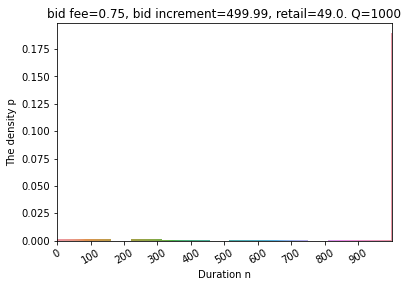

Plot is DONE


In [61]:
index_i = 28
key_i_forplot =  get_key_from_index(index_i)

plt.xlabel("Duration n")
plt.ylabel("The density p")
plt.title("bid fee={0}, bid increment={1}, retail={2}. Q={3}".format(float(key_i_forplot[0])*0.01,key_i_forplot[1],key_i_forplot[2],K))

ax = sns.barplot(x = N[key_i_forplot],y=P[key_i_forplot])

# 设置刻度
plt.xticks(np.arange(0, K, step=100),rotation=30)

plt.show()
print("Plot is DONE")
